# Notebook
In this notebook, we present the major experimental findings.

## PE-UCRL in a polarising recommender engine

### Initialisations

Choose the configurations file by altering the path below.

In [1]:
config_file_path = "config_files/peucrl_polarisation_3.json"

To run the notebook cell below, ```PilotExperimentation``` and ```gym_cellular``` have to be cloned as two separate directories in the same directory.
The notebook cell reads necessary files, imports necessary packages, and instantiates the environment and agent classes.

In [2]:
# import packages
from agents import PeUcrlAgent
from copy import deepcopy
from json import load
import gymnasium as gym
!cd ..; pip3 install -e gym-cellular -q
import gym_cellular
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from sys import stdout

# import configurations
config_file = open(config_file_path, 'r')
config = load(config_file)

# instantiate environment
env = gym.make(
    config["environment_version"],
    n_users=config["n_users"],
    n_user_states=config["n_user_states"],
    n_recommendations=config["n_recommendations"],
    n_moderators=config["n_moderators"],
    seed=config["environment_seed"],
)

# initialise environment
initial_policy = env.get_initial_policy()

# instantiate agent
agt = PeUcrlAgent(
    confidence_level=config["confidence_level"],
    accuracy=config["accuracy"],
    n_cells=config["n_users"],
    n_intracellular_states=config["n_user_states"] * 2,
    cellular_encoding=env.cellular_encoding,
    n_intracellular_actions=config["n_recommendations"],
    cellular_decoding=env.cellular_decoding,
    reward_function=env.tabular_reward_function,
    cell_classes=config["cell_classes"],
    cell_labelling_function=config["cell_labelling_function"],
    regulatory_constraints=config["regulatory_constraints"],
    initial_policy=initial_policy,
)

# print
print("configurations:")
pprint(config)

configurations:
{'accuracy': 0.9,
 'cell_classes': ['children', 'nonconsenting'],
 'cell_labelling_function': [[], [1]],
 'confidence_level': 0.95,
 'environment_seed': 4884,
 'environment_version': 'gym_cellular/Polarisation-v2',
 'max_time_steps': 500000,
 'n_moderators': 2,
 'n_recommendations': 3,
 'n_user_states': 5,
 'n_users': 2,
 'regulatory_constraints': 'P>=0.5 [ G n <= 1]',
 'reset_seed': 88}


### Explore

The agent is run in the environment in the notebook cell below, and data is collected.

In [3]:
# initialise data-saving structures
reward_cumulation = np.zeros(config["max_time_steps"]) * np.nan
side_effects_incidence = np.zeros(config["max_time_steps"]) * np.nan
ns_between_time_steps = np.zeros(config["max_time_steps"]) * np.nan
ns_between_episodes = np.zeros(config["max_time_steps"]) * np.nan

# initialise environment
state, info = env.reset()

# print
print("state:", state)
print("time step:", 0, "\n")

for time_step in range(config["max_time_steps"]):

    action = agt.sample_action(state)
    #print("action:", action)
    state, reward, terminated, truncated, info = env.step(action)
    reward_cumulation[time_step] = reward
    side_effects_incidence[time_step] = env.get_side_effects_incidence()
    agt.update(state, reward, info["side_effects"])
    ns_between_time_steps[time_step] = agt.get_ns_between_time_steps()
    ns_between_episodes[time_step] = agt.get_ns_between_episodes()

    if terminated or truncated:
        break

    # print
    if time_step <= 0:
        print("action:", action, "\nstate:", state, "\nreward:", reward, "\nside effects:")
        pprint(info["side_effects"])
        print("time step:", time_step + 1, '\n\n', end='\r')
    elif time_step >= config["max_time_steps"] - 1:
        print("\n\naction:", action, "\nstate:", state, "\nreward:", reward, "\nside effects:")
        pprint(info["side_effects"])
        print("time step:", time_step + 1)
    else:
        stdout.write('\033[3K')
        print("time step:", time_step + 1, end='\r')

state: {'polarisation': array([4, 4]), 'two_way_polarisable': array([0, 1])}
time step: 0 

action: [0 0] 
state: {'polarisation': array([3, 3]), 'two_way_polarisable': array([0, 1])} 
reward: 0.13265173137353417 
side effects:
array([['safe', 'silent'],
       ['silent', 'safe']], dtype='<U6')
time step: 1 

time step: 499999

action: [1 1] 
state: {'polarisation': array([3, 2]), 'two_way_polarisable': array([0, 1])} 
reward: 0.07918495031483792 
side effects:
array([['safe', 'silent'],
       ['silent', 'unsafe']], dtype='<U6')
time step: 500000


In [4]:
print("\nnumber of policy changes:", agt.n_policy_changes)


number of policy changes: 1


### Results

In the notebook cell below, side effects incidence and reward respectively are plotted against the number of time steps.

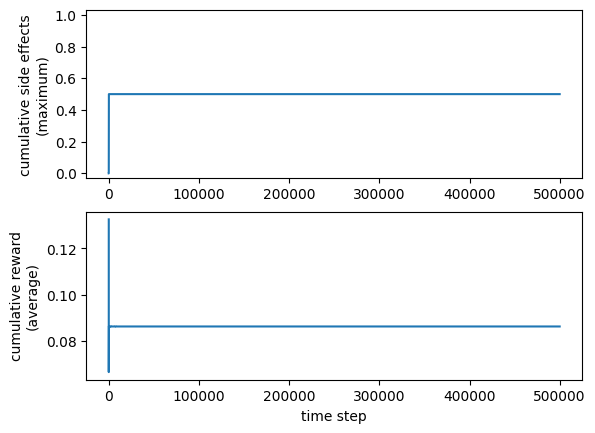

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1)
x = np.arange(1, config["max_time_steps"] + 1)
ax2.set_xlabel("time step")
ax1.set_ylabel("cumulative side effects\n(maximum)")
ax1.set_ylim(-0.03, 1.03)
d = pd.Series(side_effects_incidence)
y = d.cummax()
ax1.plot(x, y)
ax2.set_ylabel("cumulative reward\n(average)")
d = pd.Series(reward_cumulation)
y = d.cumsum()/np.arange(1, config["max_time_steps"] + 1)
ax2.plot(x, y)

plt.show(fig)

In the notebook cell below, a table is printed showing the time to perform the between time step computations as well as the between episodes computations.

In [6]:
table = [
    [np.nanmean(ns_between_time_steps)/1e9, np.nanstd(ns_between_time_steps)/1e9, np.count_nonzero(~np.isnan(ns_between_time_steps))],
    [np.nanmean(ns_between_episodes)/1e9, np.nanstd(ns_between_episodes)/1e9, np.count_nonzero(~np.isnan(ns_between_episodes))],
]
df = pd.DataFrame(table, columns=["mean (s)", "standard devation (s)", "number of samples"], index=["between time steps", "between episodes"])

print(df)

                     mean (s)  standard devation (s)  number of samples
between time steps   0.010145               0.000402             500000
between episodes    21.210781               0.405071                 20


In [7]:
print("max transition error:", np.amax(agt.transition_errors))
min_error = np.amin(agt.transition_errors)
arg_min_error = np.unravel_index(np.argmin(agt.transition_errors), agt.transition_errors.shape)
estimate = np.amin(agt.transition_estimates[arg_min_error[0], arg_min_error[1], :])
print("number of state action pairs with confidence interval < 1:", len(np.argwhere(agt.transition_errors < 1)))
print("number of state action pairs with confidence interval < 0.5:", len(np.argwhere(agt.transition_errors < 0.5)))
print("transition with least uncertainty:", estimate, "±", min_error)
print("all transition functions with non-0 estimates:")
X = np.argwhere(agt.transition_estimates > 0)
for x in X:
    print(agt.transition_estimates[x[0], x[1], x[2]], "±", agt.transition_errors[x[0], x[1]])

max transition error: 146.9205955114855
number of state action pairs with confidence interval < 1: 9
number of state action pairs with confidence interval < 0.5: 9
transition with least uncertainty: 0.0 ± 0.2869449840891161
all transition functions with non-0 estimates:
1.0 ± 0.40581464602397355
1.0 ± 33.70589623996741


In [9]:
min_error = np.amin(agt.intracellular_transition_errors)
arg_min_error = np.unravel_index(np.argmin(agt.intracellular_transition_errors), agt.intracellular_transition_errors.shape)
estimate = np.amin(agt.intracellular_transition_estimates[arg_min_error[0], arg_min_error[1], :])
print("number of intracellular state action pairs with confidence interval < 1:", len(np.argwhere(agt.intracellular_transition_errors < 1)))
print("number of intracellular state action pairs with confidence interval < 0.5:", len(np.argwhere(agt.intracellular_transition_errors < 0.5)))
print("intracellular transition with least uncertainty:", estimate, "±", min_error)
print("all intracellular transition functions with non-0 estimates:")
X = np.argwhere(agt.intracellular_transition_estimates > 0)
for x in X:
    print(agt.intracellular_transition_estimates[x[0], x[1], x[2]], "±", agt.intracellular_transition_errors[x[0], x[1]])

number of intracellular state action pairs with confidence interval < 1: 3
number of intracellular state action pairs with confidence interval < 0.5: 3
intracellular transition with least uncertainty: 0.0 ± 0.0874501281433411
all intracellular transition functions with non-0 estimates:
1.0 ± 44.77455100982496
1.0 ± 0.0874501281433411
1.0 ± 0.12367339313918052
1.0 ± 44.77455100982496
